<a href="https://colab.research.google.com/github/VavRe/nlp-ut/blob/main/CA3/Q1_Twitter_Sentiment_Analysis_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

--2023-05-14 16:03:27--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2023-05-14 16:03:27--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  34.0MB/s    in 2.3s    

2023-05-14 16:03:30 (34.0 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, RNN
from keras.models import Sequential


#Preprocessing

In [ ]:
columns = ["sentiment","id","datetime","query","user","tweet"]
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="latin-1", names=columns)

In [ ]:
df["sentiment"].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [ ]:
df = df.loc[:,["sentiment","tweet"]]
df

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
from sklearn.model_selection import train_test_split

samples_fraction = 0.025
stratify_on = "sentiment"

_, dataset = train_test_split(df, stratify=df[stratify_on], 
                                 test_size=samples_fraction,
                                 random_state=76)

# Reset the index of the sampled DataFrame
dataset.reset_index(drop=True, inplace=True)


In [ ]:
dataset["sentiment"].value_counts()

0    20000
4    20000
Name: sentiment, dtype: int64

In [ ]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = stopwords.words('english')

def preprocess_tweet(tweet, remove_stopwords=True, stem_words=True, handle_negation=True):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs, mentions, and hashtags
    tweet = re.sub(r"http\S+|www\S+|https\S+|\@\w+|\#\w+", "", tweet)
    
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove stopwords if specified
    if remove_stopwords:
        tweet_tokens = tweet.split()
        tweet = " ".join([word for word in tweet_tokens if word not in stop_words])
    
    # Stem words if specified
    if stem_words:
        stemmer = PorterStemmer()
        tweet_tokens = tweet.split()
        tweet = " ".join([stemmer.stem(word) for word in tweet_tokens])
        
    # Handle negation if specified
    if handle_negation:
        tweet_tokens = word_tokenize(tweet)
        negation_flag = False
        negated_tokens = []
        for i, token in enumerate(tweet_tokens):
            if token in ["not", "n't", "no"]:
                negation_flag = True
            elif negation_flag:
                negated_tokens.append("not_" + token)
                negation_flag = False
            else:
                negated_tokens.append(token)
        tweet = " ".join(negated_tokens)
    
    return tweet


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from tqdm import tqdm
tqdm.pandas()


dataset["tweet"] = dataset["tweet"].progress_apply(preprocess_tweet)

100%|██████████| 40000/40000 [00:11<00:00, 3336.25it/s]


In [ ]:
from keras.utils import to_categorical
X = dataset["tweet"]
y = dataset["sentiment"]

In [ ]:
y = y.replace(4,1)
y = y.replace(4,1)

In [ ]:
import gc

del df
gc.collect() # collect garbage 

0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [ ]:
vocab_size = 15000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Pad the sequences to a fixed length
max_length = 150
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)


# GloVe RNN

## Process and Train

In [ ]:
!pip install kaggle ;
!mkdir ~/.kaggle/ ;
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ ;
!chmod 600 ~/.kaggle/kaggle.json ;
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
!unzip  /content/glove-global-vectors-for-word-representation.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 452M/458M [00:03<00:00, 108MB/s]
100% 458M/458M [00:03<00:00, 124MB/s]
Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [ ]:
# # Use one-hot vectors for one option
# X_train_onehot = tokenizer.sequences_to_matrix(X_train_seq, mode='binary')
# X_test_onehot = tokenizer.sequences_to_matrix(X_test_seq, mode='binary')

# Use GloVe embeddings for another option
glove_embeddings_index = {}
with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs
embedding_dim = 200
glove_embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM, Dropout,SimpleRNN, GRU

filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.01)


RNN_glove = Sequential()
RNN_glove.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[glove_embedding_matrix], trainable=False))
RNN_glove.add(GRU(150))
RNN_glove.add(Dropout(0.2))
RNN_glove.add(Dense(2, activation='softmax'))
RNN_glove.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


hist = RNN_glove.fit(X_train_pad, y_train, epochs=100, batch_size=256, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.6666
Epoch 1: val_loss improved from inf to 0.55422, saving model to my_best_model.hdf5
100/100 [==============================] - 13s 36ms/step - loss: 0.6113 - accuracy: 0.6666 - val_loss: 0.5542 - val_accuracy: 0.7123
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.7266
Epoch 2: val_loss improved from 0.55422 to 0.54230, saving model to my_best_model.hdf5
100/100 [==============================] - 3s 28ms/step - loss: 0.5377 - accuracy: 0.7266 - val_loss: 0.5423 - val_accuracy: 0.7314
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5146 - accuracy: 0.7451
Epoch 3: val_loss improved from 0.54230 to 0.54026, saving model to my_best_model.hdf5
100/100 [==============================] - 3s 30ms/step - loss: 0.5141 - accuracy: 0.7454 - val_loss: 0.5403 - val_accuracy: 0.7286
Epoch 4/100
 99/100 [============================>.] - 

## Results

In [ ]:
y_pred = RNN_glove.predict(X_test_pad)

250/250 [==============================] - 1s 4ms/step


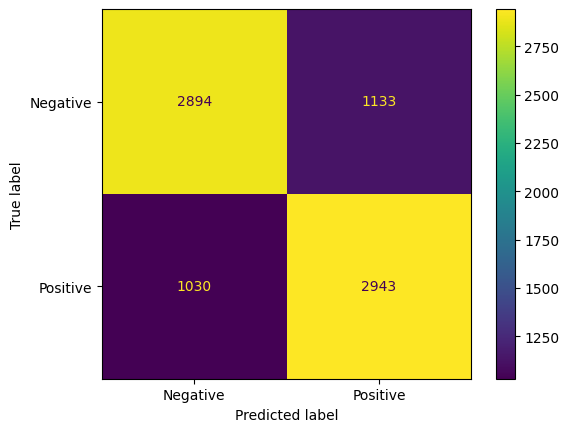

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))


              precision    recall  f1-score   support

    Negative       0.74      0.72      0.73      4027
    Positive       0.72      0.74      0.73      3973

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000



# Word2Vec RNN

## Process and Train

In [ ]:
tqdm.pandas()
dataset["tokenized"] = dataset["tweet"].progress_apply(word_tokenize)

100%|██████████| 40000/40000 [00:04<00:00, 8298.82it/s]


In [ ]:
dataset["tokenized"]

0                                [come, back, douch, lmao]
1        [come, friday, game, alway, send, preorder, ga...
2               [hahah, aww, suck, seem, like, someth, id]
3         [teacher, appreci, quotgradegrubbingquot, teach]
4              [drama, coursework, revis, n, school, suck]
                               ...                        
39995              [anyon, els, go, loservil, music, aaah]
39996                                         [that, fair]
39997    [lie, dr, paul, ekman, text, relat, facial, ex...
39998    [noi, think, would, think, crazi, polit, tell,...
39999                                         [hi, ghosti]
Name: tokenized, Length: 40000, dtype: object

In [ ]:
import gensim
from gensim.models import Word2Vec


w2v_model = Word2Vec(dataset["tokenized"].to_numpy(), vector_size=embedding_dim, window=5, min_count=1, workers=4)


In [ ]:
w2v_embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    try: 
        embedding_vector = w2v_model.wv.get_vector(word)
    except KeyError:
        print(f"the word {word} is not available")
    if embedding_vector is not None:
        w2v_embedding_matrix[i] = embedding_vector


the word not is not available
the word o is not available
the word t is not available
the word has is not available
the word allru is not available
the word sela is not available
the word roxy is not available
the word peacock is not available
the word tvd is not available
the word the is not available
the word wockeez is not available
the word titch is not available
the word aier is not available
the word brokenanvil is not available
the word twittercomtmac is not available


In [ ]:
filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.01)


RNN_w2v = Sequential()
RNN_w2v.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[w2v_embedding_matrix], trainable=False))
RNN_w2v.add(GRU(150))
RNN_w2v.add(Dropout(0.2))
RNN_w2v.add(Dense(2, activation='softmax'))
RNN_w2v.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


hist = RNN_w2v.fit(X_train_pad, y_train, epochs=100, batch_size=256, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
 98/100 [============================>.] - ETA: 0s - loss: 0.7071 - accuracy: 0.5654
Epoch 1: val_loss improved from inf to 0.64744, saving model to my_best_model.hdf5
100/100 [==============================] - 4s 28ms/step - loss: 0.7059 - accuracy: 0.5661 - val_loss: 0.6474 - val_accuracy: 0.6145
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6276
Epoch 2: val_loss improved from 0.64744 to 0.63124, saving model to my_best_model.hdf5
100/100 [==============================] - 3s 26ms/step - loss: 0.6385 - accuracy: 0.6276 - val_loss: 0.6312 - val_accuracy: 0.6394
Epoch 3/100
 98/100 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.6354
Epoch 3: val_loss improved from 0.63124 to 0.62571, saving model to my_best_model.hdf5
100/100 [==============================] - 3s 27ms/step - loss: 0.6290 - accuracy: 0.6360 - val_loss: 0.6257 - val_accuracy: 0.6447
Epoch 4/100
 99/100 [============================>.] - E

In [ ]:
y_pred = RNN_w2v.predict(X_test_pad)

250/250 [==============================] - 1s 4ms/step


## Results

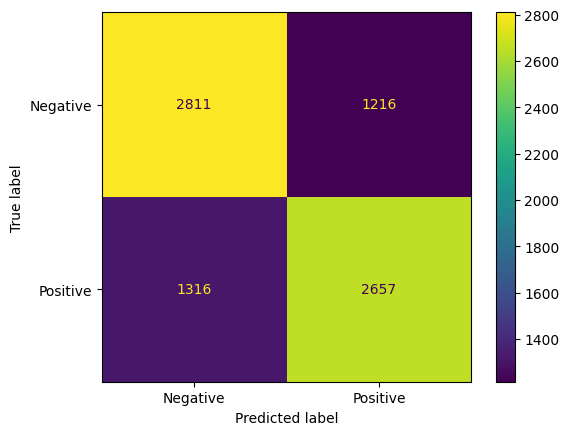

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))


              precision    recall  f1-score   support

    Negative       0.68      0.70      0.69      4027
    Positive       0.69      0.67      0.68      3973

    accuracy                           0.68      8000
   macro avg       0.68      0.68      0.68      8000
weighted avg       0.68      0.68      0.68      8000



#One-Hot RNN

## Process and Train

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Define a sample text data

# Initialize the CountVectorizer
vectorizer = CountVectorizer(binary=True, max_features=5000 )

# Fit the vectorizer to the text data
vectorizer.fit(X_train)

# # Transform the text data into a one-hot encoded matrix
X_train_onehot = vectorizer.transform(X_train).toarray()
X_test_onehot = vectorizer.transform(X_test).toarray()

# Print the one-hot encoded data
# type(X_train_onehot)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM, Dropout,SimpleRNN,Reshape
import tensorflow as tf

filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
timesteps = 1
vocab_size = 5000
input_shape = (vocab_size,)

RNN_onehot = Sequential()
RNN_onehot.add(Dense(units=150, activation='relu', input_shape=input_shape))
RNN_onehot.add(Reshape((1, 150)))
RNN_onehot.add(GRU(150))
RNN_onehot.add(Dropout(0.2))
RNN_onehot.add(Dense(2, activation='softmax'))
RNN_onehot.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


# X_train = X_train.to_numpy().reshape((X_train.shape[0], timesteps, vocab_size))
hist = RNN_onehot.fit(X_train_onehot, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
796/800 [============================>.] - ETA: 0s - loss: 0.5591 - accuracy: 0.7155
Epoch 1: val_loss improved from inf to 0.51981, saving model to my_best_model.hdf5
800/800 [==============================] - 8s 7ms/step - loss: 0.5589 - accuracy: 0.7155 - val_loss: 0.5198 - val_accuracy: 0.7497
Epoch 2/100
793/800 [============================>.] - ETA: 0s - loss: 0.4174 - accuracy: 0.8099
Epoch 2: val_loss did not improve from 0.51981
800/800 [==============================] - 4s 5ms/step - loss: 0.4180 - accuracy: 0.8093 - val_loss: 0.5467 - val_accuracy: 0.7452
Epoch 3/100
796/800 [============================>.] - ETA: 0s - loss: 0.2459 - accuracy: 0.8947
Epoch 3: val_loss did not improve from 0.51981
800/800 [==============================] - 4s 5ms/step - loss: 0.2460 - accuracy: 0.8946 - val_loss: 0.7097 - val_accuracy: 0.7264
Epoch 4/100
792/800 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9499
Epoch 4: val_loss did not improve from 0.5

250/250 [==============================] - 1s 2ms/step


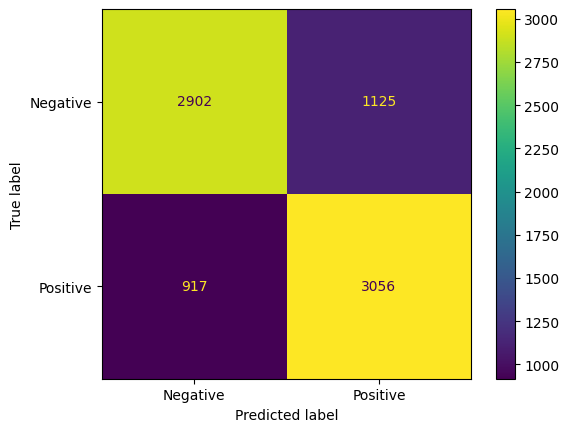

              precision    recall  f1-score   support

    Negative       0.76      0.72      0.74      4027
    Positive       0.73      0.77      0.75      3973

    accuracy                           0.74      8000
   macro avg       0.75      0.74      0.74      8000
weighted avg       0.75      0.74      0.74      8000



In [ ]:
y_pred = RNN_onehot.predict(X_test_onehot)
     

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()

     

from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

